In [2]:
import os
import numpy as np
import pandas as pd
from scipy import stats

import argus_shapes
import pulse2percept.implants as p2pi

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-05-04 14:46:45,247 [pulse2percept] [INFO] Welcome to pulse2percept


In [3]:
datafolder = os.environ['ARGUS_SHAPES_DATA']
subjectdata = argus_shapes.load_subjects(os.path.join(datafolder, 'subjects.csv'))

In [4]:
subjects = subjectdata.index.sort_values()

In [13]:
features = []
targets = []
for subject in subjects:
    f, t = argus_shapes.load_data(os.path.join(datafolder, 'drawings_single.csv'), 
                                  subject=subject, amp=2.0, random_state=42)
    f, t = argus_shapes.calc_mean_images(f, t, max_area=1.5)
    implant_type = subjectdata.loc[subject, 'implant_type']
    argus = implant_type(x_center=subjectdata.loc[subject, 'implant_x'],
                         y_center=subjectdata.loc[subject, 'implant_y'],
                         rot=subjectdata.loc[subject, 'implant_rot'])
    f['x_electrode'] = [argus[row['electrode']].x_center for _, row in t.iterrows()]
    f['y_electrode'] = [argus[row['electrode']].y_center for _, row in t.iterrows()]
    f['xrange'] = [subjectdata.loc[subject, 'xrange'] for _ in f.iterrows()]
    f['yrange'] = [subjectdata.loc[subject, 'yrange'] for _ in f.iterrows()]
    features.append(f)
    targets.append(t)

In [14]:
Xy = pd.concat((pd.concat(features), pd.concat(targets).drop(columns='electrode')), axis=1)

In [15]:
cols = ['x_center', 'y_center']
markers = ['o', 's', 'v', '^']
# colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']

In [16]:
Xy.columns

Index(['amp', 'electrode', 'img_shape', 'subject', 'x_electrode',
       'y_electrode', 'xrange', 'yrange', 'area', 'compactness',
       'eccentricity', 'image', 'orientation', 'x_center', 'y_center'],
      dtype='object')

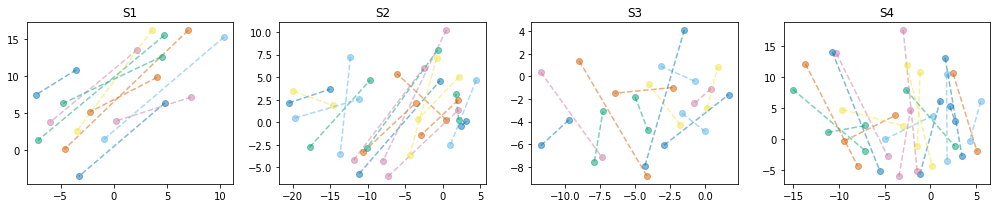

In [23]:
fig, axes = plt.subplots(ncols=len(subjects), figsize=(14, 3))
for (subject, data), ax in zip(Xy.groupby('subject', sort=False), axes):
    for _, row in data.iterrows():
        px = row['x_center'] / row['img_shape'][1] * np.diff(row['xrange'])[0] + row['xrange'][0]
        py = row['y_center'] / row['img_shape'][0] * np.diff(row['yrange'])[0] + row['yrange'][0]
        ex = row['x_electrode'] / 288
        ey = -row['y_electrode'] / 288
        ax.plot([px, ex], [py, ey], 'o--', alpha=0.5)
        ax.set_title(subject)
fig.tight_layout()